# BMIN 5210 Final Project  

### Selina Chen, Sabrina Weng

In [2]:
from sklearn.model_selection import train_test_split, StratifiedKFold, StratifiedShuffleSplit, GridSearchCV, RandomizedSearchCV
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier, AdaBoostClassifier, VotingClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from xgboost.sklearn import XGBClassifier
from sklearn.tree import DecisionTreeClassifier

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import cross_val_score
from sklearn.metrics import f1_score, roc_auc_score, precision_score
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, mean_absolute_error, roc_curve, auc
from sklearn.linear_model import LogisticRegression
from sklearn.impute import SimpleImputer

from tensorflow import keras
from keras.models import Sequential
from keras.layers import Flatten, BatchNormalization, Dense, Dropout
from keras.utils import to_categorical

import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sys
import warnings
from lightgbm import LGBMClassifier, LGBMRegressor



## Exploratory Data Analysis (EDA)

In [3]:
df = pd.read_csv("MIMIC.csv")
df.head(5)

,group,ID,outcome,age,gendera,BMI,hypertensive,atrialfibrillation,CHD with no MI,diabetes,...,Blood sodium,Blood calcium,Chloride,Anion gap,Magnesium ion,PH,Bicarbonate,Lactic acid,PCO2,EF
0,1,125047,0.0,72,1,37.588179,0,0,0,1,...,138.750000,7.463636,109.166667,13.166667,2.618182,7.230,21.166667,0.5,40.0,55
1,1,139812,0.0,75,2,NaN,0,0,0,0,...,138.888889,8.162500,98.444444,11.444444,1.887500,7.225,33.444444,0.5,78.0,55
2,1,109787,0.0,83,2,26.572634,0,0,0,0,...,140.714286,8.266667,105.857143,10.000000,2.157143,7.268,30.571429,0.5,71.5,35
3,1,130587,0.0,43,2,83.264629,0,0,0,0,...,138.500000,9.476923,92.071429,12.357143,1.942857,7.370,38.571429,0.6,75.0,55
4,1,138290,0.0,75,2,31.824842,1,0,0,0,...,136.666667,8.733333,104.500000,15.166667,1.650000,7.250,22.000000,0.6,50.0,55


In [8]:
df.shape

(1177, 51)

In [ ]:
# rename gendera to gender
df.rename(columns={'gendera': 'gender'}, inplace=True)

By observing the dataset, we consider the `ids` and `groups` are unnecessary features in our prediction, so we dropped them.

In [ ]:
df = df.drop(['group','ID'], axis=1)

Then, we can see the counts of `NaN` in each column, the percentage of `NaN`, and the type of the columns.

In [ ]:
def NaN_info(df):
    global null_view
    try:
        null_view = df[[col for col in df.columns if df[col].isna().sum() > 0]].isna().sum().sort_values(ascending = False)
        null_view = pd.DataFrame(null_view, columns=['NaN_counts'])
        null_view['%'] = null_view.NaN_counts.apply(lambda x: round((x/len(df))*100, 2))
        null_view['type'] = df.dtypes
    except:
        return null_view
    return null_view

In [ ]:
NaN_info(df)

,NaN_counts,%,type
PCO2,294,24.98,float64
PH,292,24.81,float64
Basophils,259,22.01,float64
Lactic acid,229,19.46,float64
BMI,215,18.27,float64
Creatine kinase,165,14.02,float64
Lymphocyte,145,12.32,float64
Neutrophils,144,12.23,float64
Urine output,36,3.06,float64
INR,20,1.70,float64


In [ ]:
# drop duplicates
def drop_na(df, target=None):

    df.drop_duplicates(inplace=True)
    df.reset_index(drop=True, inplace=True)

    if target:
        nan = df[df[target].isnull()]
        indeces = list(nan.index)

        df = df.drop(df.index[indeces])
        df.reset_index(drop=True, inplace=True)
        print(f'Final shape: {df.shape}\n')
    return df

In [ ]:
target = "outcome"
drop_na(df, target)

Final shape: (1176, 49)



,outcome,age,gender,BMI,hypertensive,atrialfibrillation,CHD with no MI,diabetes,deficiencyanemias,depression,...,Blood sodium,Blood calcium,Chloride,Anion gap,Magnesium ion,PH,Bicarbonate,Lactic acid,PCO2,EF
0,0.0,72,1,37.588179,0,0,0,1,1,0,...,138.750000,7.463636,109.166667,13.166667,2.618182,7.230,21.166667,0.5,40.0,55
1,0.0,75,2,NaN,0,0,0,0,1,0,...,138.888889,8.162500,98.444444,11.444444,1.887500,7.225,33.444444,0.5,78.0,55
2,0.0,83,2,26.572634,0,0,0,0,1,0,...,140.714286,8.266667,105.857143,10.000000,2.157143,7.268,30.571429,0.5,71.5,35
3,0.0,43,2,83.264629,0,0,0,0,0,0,...,138.500000,9.476923,92.071429,12.357143,1.942857,7.370,38.571429,0.6,75.0,55
4,0.0,75,2,31.824842,1,0,0,0,1,0,...,136.666667,8.733333,104.500000,15.166667,1.650000,7.250,22.000000,0.6,50.0,55
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1171,0.0,62,1,25.516870,1,1,0,1,0,1,...,136.714286,10.271429,94.428571,20.142857,2.714286,NaN,27.714286,NaN,NaN,40
1172,0.0,78,1,25.822710,0,1,0,1,0,1,...,135.680000,10.523529,101.720000,18.160000,2.012500,NaN,20.480000,NaN,NaN,30
1173,0.0,85,2,23.891779,1,1,0,1,1,0,...,136.000000,8.466667,97.285714,14.000000,2.028571,NaN,28.857143,NaN,NaN,55
1174,0.0,79,2,35.288554,0,0,1,1,1,1,...,140.000000,8.183333,104.000000,15.750000,2.090000,NaN,24.375000,NaN,NaN,25


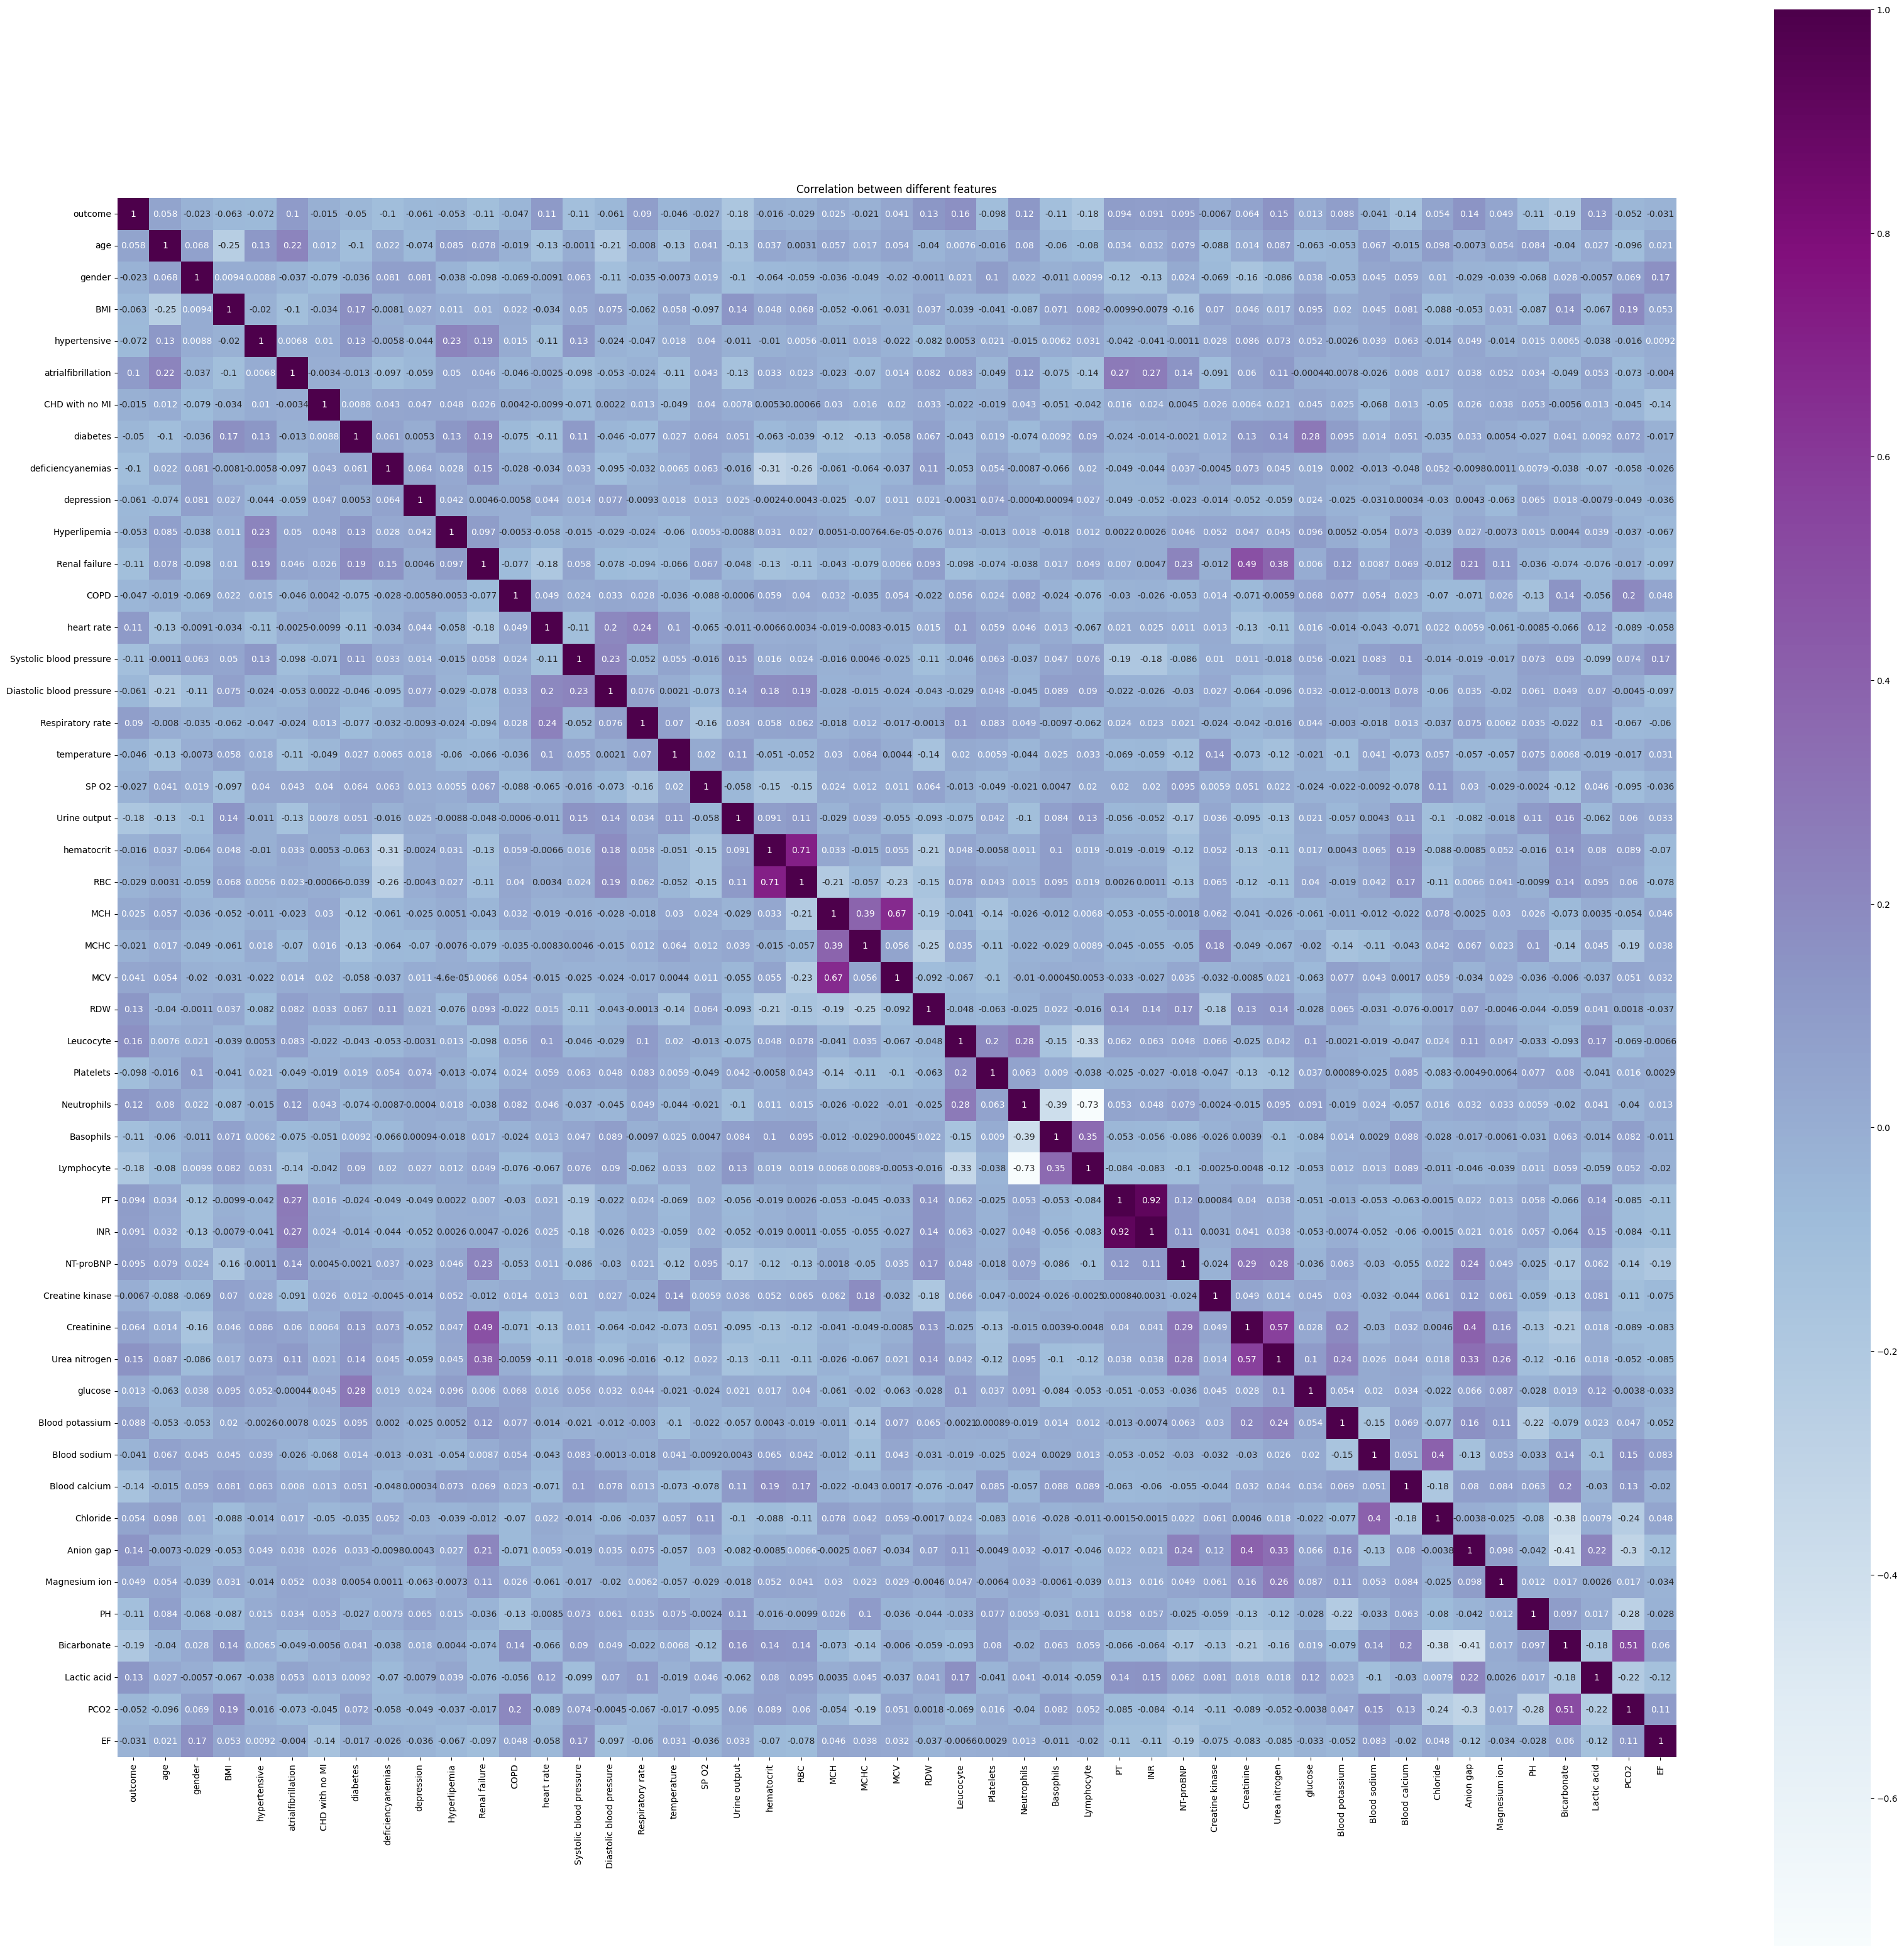

In [ ]:
import seaborn as sns
correlation = df.corr(method = 'kendall')
plt.figure(figsize=(40,40))
sns.heatmap(correlation, vmax=1, square=True,annot=True,cmap='BuPu')

plt.title('Correlation between different features')
plt.show()

In [ ]:
correlation_matrix = df.corr()
outcome_correlation = correlation_matrix['outcome']
outcome_correlation = outcome_correlation.drop('outcome')
print(outcome_correlation)


age                         0.064510
gender                     -0.022690
BMI                        -0.062086
hypertensive               -0.072441
atrialfibrillation          0.100975
CHD with no MI             -0.014694
diabetes                   -0.049997
deficiencyanemias          -0.099513
depression                 -0.060883
Hyperlipemia               -0.053466
Renal failure              -0.108500
COPD                       -0.047324
heart rate                  0.129750
Systolic blood pressure    -0.132857
Diastolic blood pressure   -0.087403
Respiratory rate            0.117015
temperature                -0.092861
SP O2                      -0.071189
Urine output               -0.173135
hematocrit                 -0.016533
RBC                        -0.023992
MCH                         0.013387
MCHC                       -0.031885
MCV                         0.034144
RDW                         0.148089
Leucocyte                   0.208274
Platelets                  -0.088465
N

In [ ]:
# Impute missing values
imputer = SimpleImputer(strategy='median')
df_numeric = df.select_dtypes(include=[np.number])
df[df_numeric.columns] = imputer.fit_transform(df_numeric)

# Encode categorical data
encoder = LabelEncoder()
for column in df.select_dtypes(include=['object']).columns:
    df[column] = encoder.fit_transform(df[column])

# Separate the predictors and target
X = df.drop('outcome', axis=1)
y = df['outcome']

check if there are null values in the columns of the dataframe

In [ ]:
df.isnull().sum()

outcome                     0
age                         0
gender                      0
BMI                         0
hypertensive                0
atrialfibrillation          0
CHD with no MI              0
diabetes                    0
deficiencyanemias           0
depression                  0
Hyperlipemia                0
Renal failure               0
COPD                        0
heart rate                  0
Systolic blood pressure     0
Diastolic blood pressure    0
Respiratory rate            0
temperature                 0
SP O2                       0
Urine output                0
hematocrit                  0
RBC                         0
MCH                         0
MCHC                        0
MCV                         0
RDW                         0
Leucocyte                   0
Platelets                   0
Neutrophils                 0
Basophils                   0
Lymphocyte                  0
PT                          0
INR                         0
NT-proBNP 

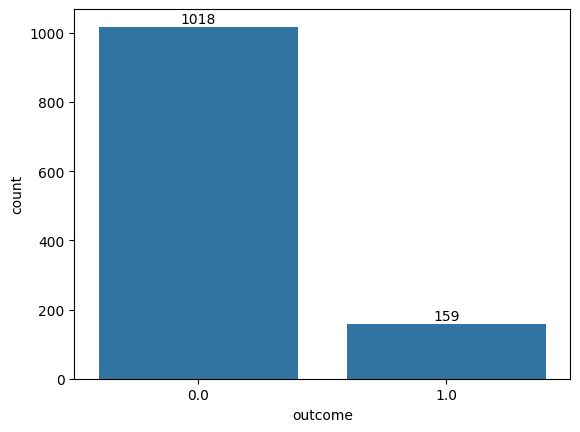

outcome
0.0    1018
1.0     159
Name: count, dtype: int64


In [ ]:
# Plotting the countplot
sns.countplot(data=df, x="outcome")

# Adding text labels for each bar
for p in plt.gca().patches:
    height = p.get_height()
    plt.gca().text(p.get_x() + p.get_width() / 2., height + 3,
                   int(height), ha='center', va='bottom')

plt.show()

# Calculate and print the counts for each outcome
outcome_counts = df['outcome'].value_counts()
print(outcome_counts)

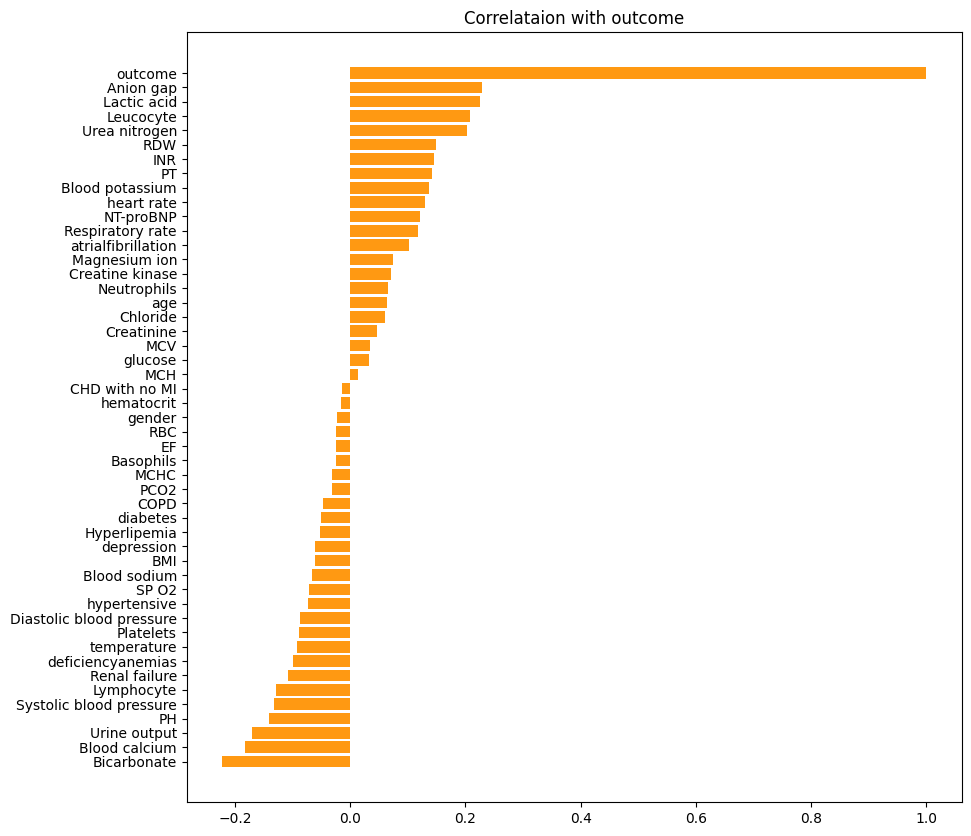

In [ ]:
# visualize correlation with the outcome column
fig = plt.figure(figsize = (10, 10))
target_corr = pd.DataFrame(df.corr()['outcome'].sort_values(ascending = True))
plt.barh(target_corr.index, target_corr['outcome'],color="#FF9912")
plt.title('Correlataion with outcome')
plt.show()

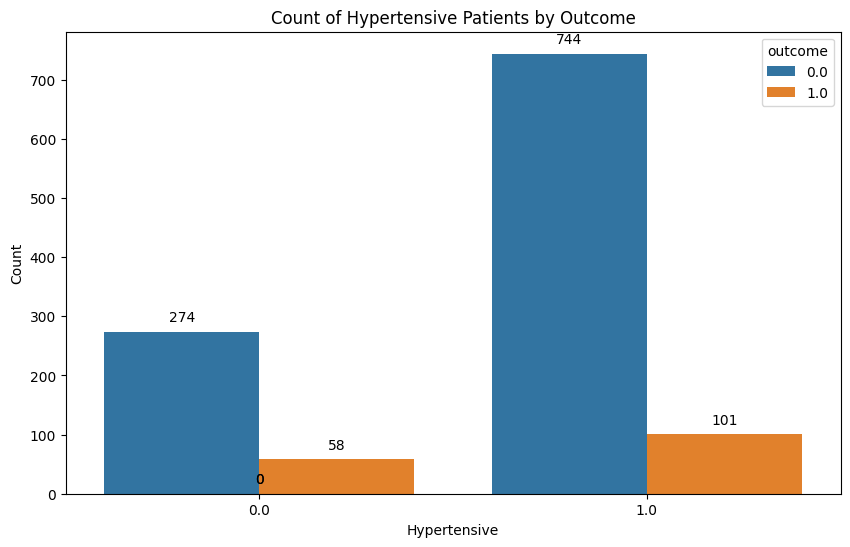

In [ ]:
# visualize the counts of hypertensive v.s. outcome
plt.figure(figsize=(10, 6))
ax = sns.countplot(data=df, x="hypertensive", hue="outcome")

for p in ax.patches:
    ax.annotate(format(p.get_height(), '.0f'),
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha = 'center',
                va = 'center',
                xytext = (0, 10),
                textcoords = 'offset points')

plt.title("Count of Hypertensive Patients by Outcome")
plt.xlabel("Hypertensive")
plt.ylabel("Count")
plt.show()

<Axes: xlabel='age', ylabel='Count'>

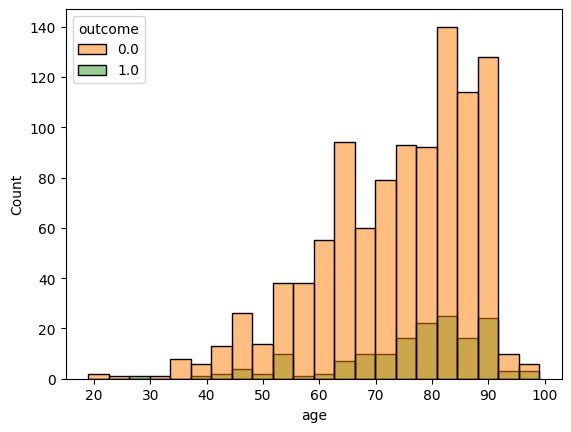

In [ ]:
# view the age v.s. outcome distribution
sns.histplot(data=df,x='age',hue='outcome',palette='Paired_r')

##Model Training and Prediction

In [ ]:
# split data into training and testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f'Spliting {len(X)} dataset into {len(X_train)} training and {len(X_test)} testing.')

Spliting 1177 dataset into 941 training and 236 testing.


###Find the best model


In order to find the best model, we define `find_best_model` function to train on 8 different models, including `Logistic Regression`, `Decision Tree`, `Random Forest`, `SVM`, `KNN`, `Naive Bayes`, `AdaBoost`, and `XGBoost`.

In [ ]:
def find_best_model(X_train, X_test, y_train, y_test):
    # Logistic Regression
    logreg = LogisticRegression(max_iter=10000)
    logreg.fit(X_train, y_train)
    logreg_acc = accuracy_score(y_test, logreg.predict(X_test))

    # Decision Tree
    decision_tree = DecisionTreeClassifier(random_state=42)
    decision_tree.fit(X_train, y_train)
    decision_tree_acc = accuracy_score(y_test, decision_tree.predict(X_test))

    # Random Forest
    random_forest = RandomForestClassifier(n_estimators=100, random_state=42)
    random_forest.fit(X_train, y_train)
    random_forest_acc = accuracy_score(y_test, random_forest.predict(X_test))

    # SVM
    svm = SVC()
    svm.fit(X_train, y_train)
    svm_acc = accuracy_score(y_test, svm.predict(X_test))

    # KNN
    knn = KNeighborsClassifier()
    knn.fit(X_train, y_train)
    knn_acc = accuracy_score(y_test, knn.predict(X_test))

    # Naive Bayes
    naive_bayes = GaussianNB()
    naive_bayes.fit(X_train, y_train)
    naive_bayes_acc = accuracy_score(y_test, naive_bayes.predict(X_test))

    # AdaBoost
    adaboost = AdaBoostClassifier()
    adaboost.fit(X_train, y_train)
    adaboost_acc = accuracy_score(y_test, adaboost.predict(X_test))

    # XGBoost
    xgb = XGBClassifier()
    xgb.fit(X_train, y_train)
    xgb_acc = accuracy_score(y_test, xgb.predict(X_test))

    model_df = pd.DataFrame({
        'Model': ['Logistic Regression', 'Decision Tree', 'Random Forest', 'SVM', 'KNN', 'Naive Bayes', 'AdaBoost', 'XGBoost'],
        'Score': [logreg_acc, decision_tree_acc, random_forest_acc, svm_acc, knn_acc, naive_bayes_acc, adaboost_acc, xgb_acc]
    })
    # print(model_df.sort_values('Score', ascending=False).reset_index(drop=True))
    # Sort the DataFrame by 'Score' column in descending order and reset index
    sorted_model_df = model_df.sort_values('Score', ascending=False).reset_index(drop=True)
    display(sorted_model_df)

find_best_model(X_train, X_test, y_train, y_test)

,Model,Score
0,Logistic Regression,0.860169
1,Random Forest,0.860169
2,AdaBoost,0.847458
3,SVM,0.838983
4,XGBoost,0.834746
5,Naive Bayes,0.830508
6,KNN,0.826271
7,Decision Tree,0.771186


From the training result above, we can conclude that Logistic Regression and Random Forest have better training results of accuracy `0.86`. So as below, we showed the details of the precision, recall, and f1-score for both models seperately.

###Logistic Regression

In [ ]:
# Logistic Regression
logreg = LogisticRegression(max_iter=10000)
logreg.fit(X_train, y_train)
y_pred = logreg.predict(X_test)
logreg_acc = accuracy_score(y_test, y_pred)
print(f"Accuracy: {logreg_acc * 100:.2f}%")
print(classification_report(y_test, y_pred))

Accuracy: 86.02%
              precision    recall  f1-score   support

         0.0       0.87      0.97      0.92       198
         1.0       0.67      0.26      0.38        38

    accuracy                           0.86       236
   macro avg       0.77      0.62      0.65       236
weighted avg       0.84      0.86      0.83       236



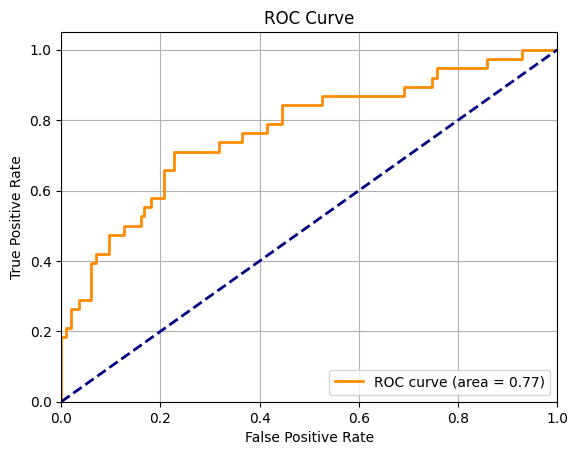

In [ ]:
# Probability scores for the positive class
y_scores = logreg.predict_proba(X_test)[:, 1]

fpr, tpr, thresholds = roc_curve(y_test, y_scores)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.grid()
plt.show()

###Random Forest

In [ ]:
random_forest = RandomForestClassifier(n_estimators=100, random_state=42)
random_forest.fit(X_train, y_train)
y_pred = random_forest.predict(X_test)
random_forest_acc = accuracy_score(y_test, y_pred)
print(f"Accuracy: {random_forest_acc * 100:.2f}%")
print(classification_report(y_test, y_pred))

Accuracy: 86.02%
              precision    recall  f1-score   support

         0.0       0.86      1.00      0.92       198
         1.0       1.00      0.13      0.23        38

    accuracy                           0.86       236
   macro avg       0.93      0.57      0.58       236
weighted avg       0.88      0.86      0.81       236



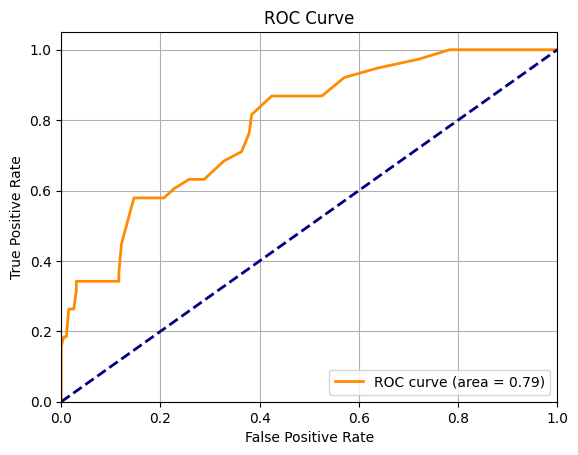

In [ ]:
# Probability scores for the positive class
y_scores = random_forest.predict_proba(X_test)[:, 1]

fpr, tpr, thresholds = roc_curve(y_test, y_scores)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.grid()
plt.show()

###Ensemble Training


Next, we tried to ensemble the 2 models.

In [ ]:
# Define base estimators
estimators = [('logreg', LogisticRegression(max_iter=10000)),
              ('random_forest', RandomForestClassifier(n_estimators=100, random_state=42))]

# Create the ensemble model
ensemble_model = VotingClassifier(estimators)

# Fit the ensemble model
ensemble_model.fit(X_train, y_train)

# Predict using the ensemble model
y_pred = ensemble_model.predict(X_test)

# Calculate accuracy
ensemble_acc = accuracy_score(y_test, y_pred)
print(f"Accuracy: {ensemble_acc * 100:.2f}%")

# Print classification report
print(classification_report(y_test, y_pred))


Accuracy: 86.02%
              precision    recall  f1-score   support

         0.0       0.86      1.00      0.92       198
         1.0       1.00      0.13      0.23        38

    accuracy                           0.86       236
   macro avg       0.93      0.57      0.58       236
weighted avg       0.88      0.86      0.81       236



From the result above, we can conclude that ensembling the 2 models will not significantly enhance the performance.

###Neural Network

Finally, we build a basic neural network architecture using the Keras library.

`BatchNormalization`: Normalizes the activations of the previous layer at each batch. It helps stabilize and speed up the training process by reducing internal covariate shift.

`Dense Layers` (128 neurons): Fully connected layers with 128 neurons and ReLU activation function. ReLU (Rectified Linear Unit) is a commonly used activation function that introduces non-linearity to the model.

`Dropout` (20%): Dropout layer with a dropout rate of 20%. Dropout randomly sets a fraction of input units to 0 during training, which helps prevent overfitting.

`Dense Layer` (2 neurons): Fully connected layer with 2 neurons and softmax activation function. Softmax activation is commonly used in multi-class classification problems to output probabilities for each class.

The model is compiled with `categorical cross-entropy loss`, `Adam optimizer`, and accuracy metrics.

In [ ]:
def NN_Model():
    keras.backend.clear_session()

    model = Sequential()
    model.add(BatchNormalization())
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.2))

    model.add(BatchNormalization())
    model.add(Dense(128, activation='relu'))

    model.add(BatchNormalization())
    model.add(Dropout(0.2))
    model.add(Dense(2, activation='softmax'))

    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

In [ ]:
# Encode target variable
encoder = LabelEncoder() # already defined
y_train_encoded = encoder.fit_transform(y_train)
y_test_encoded = encoder.transform(y_test)

# Convert labels to categorical one-hot encoding
y_train_categorical = to_categorical(y_train_encoded)
y_test_categorical = to_categorical(y_test_encoded)

# Create and compile the model
model = NN_Model()

# Train the model
history = model.fit(X_train, y_train_categorical, epochs=20, batch_size=32, validation_data=(X_test, y_test_categorical))

Epoch 1/20
30/30 [==============================] - 3s 12ms/step - loss: 0.8500 - accuracy: 0.5909 - val_loss: 6.1351 - val_accuracy: 0.1610
Epoch 2/20
30/30 [==============================] - 0s 4ms/step - loss: 0.5841 - accuracy: 0.7131 - val_loss: 2.0692 - val_accuracy: 0.1610
Epoch 3/20
30/30 [==============================] - 0s 4ms/step - loss: 0.4571 - accuracy: 0.7917 - val_loss: 1.3754 - val_accuracy: 0.2076
Epoch 4/20
30/30 [==============================] - 0s 4ms/step - loss: 0.3429 - accuracy: 0.8714 - val_loss: 0.9546 - val_accuracy: 0.4068
Epoch 5/20
30/30 [==============================] - 0s 4ms/step - loss: 0.3371 - accuracy: 0.8587 - val_loss: 0.5870 - val_accuracy: 0.6737
Epoch 6/20
30/30 [==============================] - 0s 4ms/step - loss: 0.2655 - accuracy: 0.8874 - val_loss: 0.4101 - val_accuracy: 0.8390
Epoch 7/20
30/30 [==============================] - 0s 4ms/step - loss: 0.2717 - accuracy: 0.8948 - val_loss: 0.4143 - val_accuracy: 0.8517
Epoch 8/20
30/30 [=

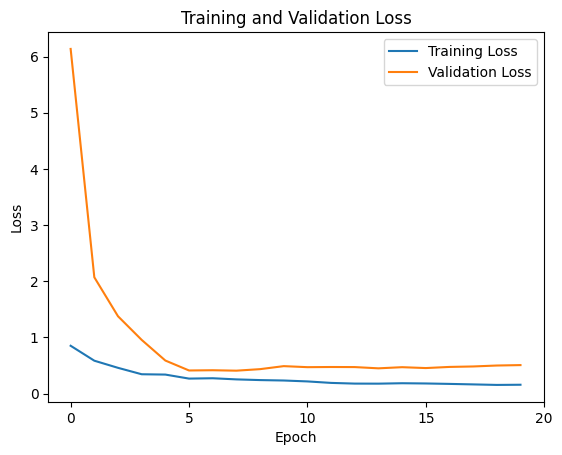

In [ ]:
# Plot training and validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.xticks([0, 5, 10, 15, 20])
plt.legend()
plt.show()

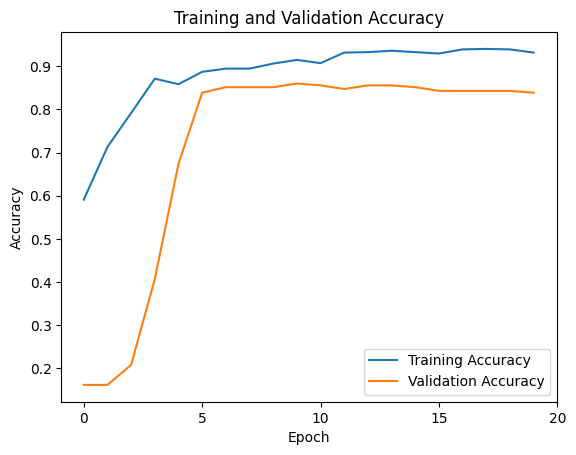

In [ ]:
# Plot training and validation accuracy
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.xticks([0, 5, 10, 15, 20])
plt.legend()
plt.show()

In [ ]:
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f'Test accuracy: {test_accuracy * 100:.2f}%')

8/8 [==============================] - 0s 4ms/step - loss: 0.5851 - accuracy: 0.9237
Test accuracy: 92.37%


Finally, we can achieve a testing accuracy of 92.37%.